Imports

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import sys
import os 

import requests 
from requests.auth import HTTPBasicAuth
import time
import re



Access Data

In [28]:
cwd = os.getcwd()
# go back a directory here
parent_dir  = os.path.dirname(cwd)

dataset = os.path.join(parent_dir, 'DataSets')
if not os.path.exists(dataset):
    print("Please run this script from the root directory.")
    sys.exit(1)

# Load the dataset
file_path = os.path.join(dataset, 'master.xlsx')
df = pd.read_excel(file_path, sheet_name = "main")

# Print the first few rows in the dataset
print("First rows")
print(df.head())

First rows
             Company Name Previous Names  Gap  \
0                  10zyme            NaN    1   
1              2.5D Print            NaN    1   
2               20 Photos            NaN    2   
3               20 Photos            NaN    2   
4  ABAKA Holdings Limited            NaN    1   

                            Sector                   Hub(s)  \
0  DigiTech/Health and Social Care  Cross-Hub: Bayes, Usher   
1    Robotics & Autonomous Systems                    Bayes   
2              Creative Industries                 EFI [CI]   
3              Creative Industries                 EFI [CI]   
4                 DigiTech/Fintech                    Bayes   

   Programme(s) attended Date started Date ended  \
0                  VBI 2   2021-11-23 2022-03-25   
1                  VBI 5   2024-10-03 2025-03-14   
2        Creative Bridge   2022-03-23 2022-05-25   
3  Resident Entrepreneur   2022-06-07 2023-01-31   
4                  AIA 1   2018-12-01 2019-05-08   

  

Some Processing

In [29]:
df = df.rename(columns={"Companies House name\n(or note Sole Trader/ Freelancer)": "Companies House name"})
df = df.rename(columns = {"Company Registration Number" : "CRN"})

Data Summary

Dataset dimensions: 846 rows, 19 columns

Program types:
Programme(s) attended
Creative Bridge                                                 98
Resident Entrepreneur                                           74
EIE 18                                                          59
EIE 19                                                          50
EIE 20                                                          48
EI Student Enterprise Support Team                              39
EIE 22                                                          36
EIE 21                                                          35
VBI 5                                                           35
Challenge Project                                               28
VBI 1                                                           27
VBI 4                                                           26
Connected Innovators                                            26
VBI 3                                             

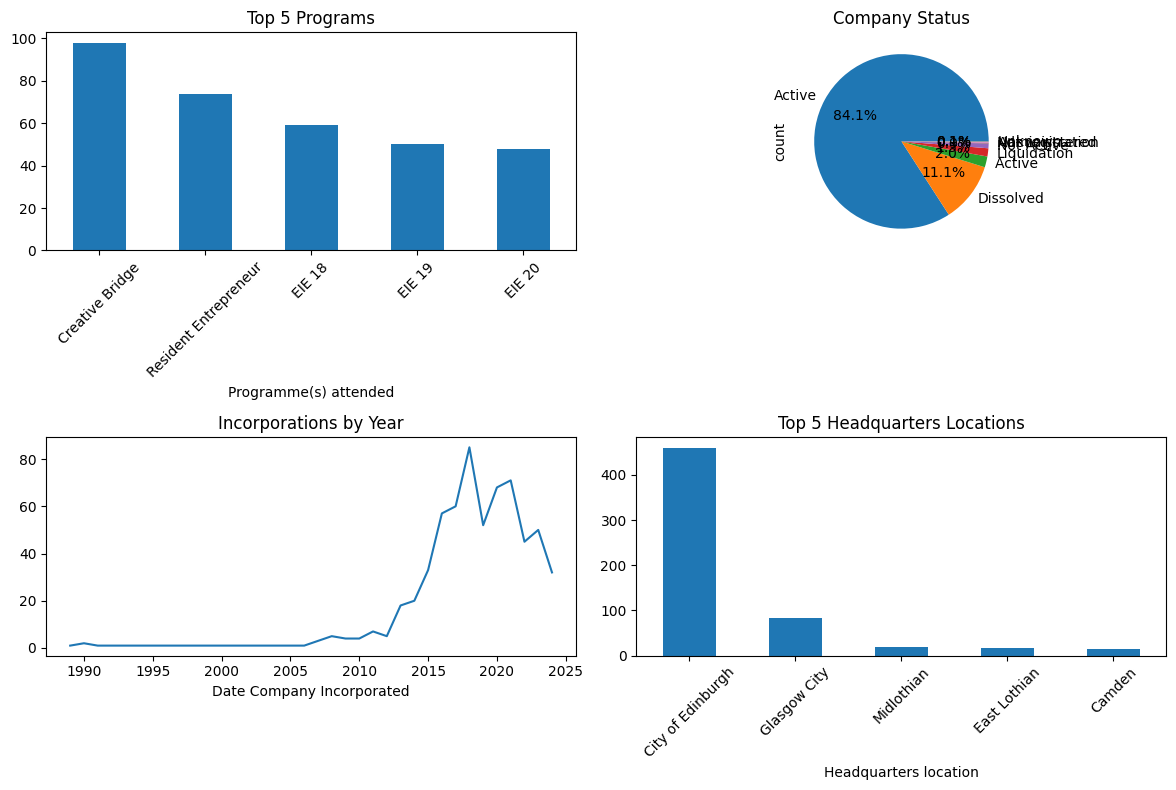

In [30]:
# Basic dataset overview
print(f"Dataset dimensions: {df.shape[0]} rows, {df.shape[1]} columns")

# Check program types and counts
print("\nProgram types:")
program_column = "Programme(s) attended"  # Using correct column name
program_counts = df[program_column].value_counts()
print(program_counts)

# Company status analysis
print("\nCompany status breakdown:")
print(df["Company Status?"].value_counts())

# Timeline analysis
print("\nIncorporation date range:")
# Add errors='coerce' to handle problematic date values
df["Date Company Incorporated"] = pd.to_datetime(df["Date Company Incorporated"], errors='coerce')
print(f"Earliest incorporation: {df['Date Company Incorporated'].min()}")
print(f"Latest incorporation: {df['Date Company Incorporated'].max()}")

# Geographic distribution
print("\nTop headquarters locations:")
print(df["Headquarters location"].value_counts().head(10))

# Industry analysis
print("\nIndustry distribution:")
industry_counts = df["Company Industry(s)"].value_counts().head(10)
print(industry_counts)

# DDI participation
print("\nDDI participation:")
print(df["DDI?"].value_counts())

# Program duration analysis - fixed column names
df["Date started"] = pd.to_datetime(df["Date started"], errors='coerce')
df["Date ended"] = pd.to_datetime(df["Date ended"], errors='coerce')
df["Program Duration (days)"] = (df["Date ended"] - df["Date started"]).dt.days
print("\nProgram duration statistics (days):")
print(df["Program Duration (days)"].describe())

# Missing data analysis
print("\nMissing data by column:")
missing = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(df) * 100).round(1)
missing_data = pd.DataFrame({'Count': missing, 'Percent': missing_percent})
print(missing_data[missing_data['Count'] > 0])

# Visualization of key aspects
plt.figure(figsize=(12, 8))

# Plot 1: Program distribution
plt.subplot(2, 2, 1)
program_counts.head(5).plot(kind='bar')
plt.title('Top 5 Programs')
plt.xticks(rotation=45)

# Plot 2: Company status
plt.subplot(2, 2, 2)
df["Company Status?"].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Company Status')

# Plot 3: Incorporations over time
plt.subplot(2, 2, 3)
df["Date Company Incorporated"].dt.year.value_counts().sort_index().plot(kind='line')
plt.title('Incorporations by Year')

# Plot 4: Geographic distribution
plt.subplot(2, 2, 4)
df["Headquarters location"].value_counts().head(5).plot(kind='bar')
plt.title('Top 5 Headquarters Locations')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [31]:
#All companies incoperated before 1995
df["Date Company Incorporated"] = pd.to_datetime(df["Date Company Incorporated"], errors = "coerce")
df.columns
pre_1995 = df[df["Date Company Incorporated"] < pd.to_datetime("1995-01-01")]
pre_1995.shape[0]
pre_1995.head(10)

,Company Name,Previous Names,Gap,Sector,Hub(s),Programme(s) attended,Date started,Date ended,Companies House name,CRN,Company Industry(s),Company Status?,Date Company Incorporated,Date Company Dissolved,Headquarters location,IRM Account ID,IRM Opportunity ID,Stages,DDI?,Program Duration (days)
399,Lung Ha Theatre Company,NaN,1,Creative Industries,EFI [CI],Community Creative Capital Tech Fund,2023-08-16,2023-10-31,Lung Ha Theatre Company,SC131622,90010,Active,1991-05-02,NaT,City of Edinburgh,NaN,NaN,NaN,Yes,76.0
589,Screen Education Edinburgh,NaN,1,Creative Industries,EFI [CI],Community Creative Tech Fund,2023-08-16,2023-10-31,Screen Education Edinburgh,CS000559,SC012460,Active,1989-05-09,NaT,City of Edinburgh,NaN,NaN,NaN,Yes,76.0
760,VISIBLE INK TELEVISION LTD,NaN,2,Creative Industries,EFI [CI],Creative Bridge,2021-02-10,2021-04-07,VISIBLE INK TELEVISION LTD,2547700,90030,Active,1990-10-11,NaT,Nottingham,NaN,NaN,NaN,Yes,56.0
761,VISIBLE INK TELEVISION LTD,NaN,2,Creative Industries,EFI [CI],Resident Entrepreneur,2021-08-01,2023-09-29,VISIBLE INK TELEVISION LTD\n\n,2547700,NaN,Active,1990-10-11,NaT,Nottingham,NaN,NaN,NaN,Yes,789.0


Filter comapnies by whether they do/don't have a CRN

In [ ]:


url = "https://api.company-information.service.gov.uk/search/companies"
API_KEY = 

REQUEST_DELAY = 0.4 #adhere to rate limits


# Ensure all companeies house names and CRN are in string format
companies_with_crn = df.copy(deep = True)
companies_with_crn["CRN"] = companies_with_crn["CRN"].astype(str)
companies_with_crn["Companies House name"].astype(str)

non_registered_mask = (
    companies_with_crn["CRN"].str.strip().str.lower().isin(['n/a', 'na', 'n.a.', 'n/a.', 'nan']) |
    companies_with_crn["CRN"].isna() |
    # Empty strings
    (companies_with_crn["CRN"].str.strip() == "") |
    # Sole traders
    companies_with_crn["CRN"].str.lower().str.contains("sole trader", na=False)
)

# Create two seperate data frames
without_crn = companies_with_crn[non_registered_mask].copy()
companies_with_crn = companies_with_crn[~non_registered_mask].copy()




        


Search companies by company registration number

In [ ]:
def is_exact_match(company_name, api_results):
    if "items" not in api_results or len(api_results["items"]) == 0:
        
        return False
    
    # Check for exact match (case sensitive)
    for item in api_results["items"]:
        if item["title"] == company_name:
            return True
    
    return False


def remove_new_lines(company_name):
    if not isinstance(company_name, str):
        return company_name
    
    normalised  = re.sub(r"^\n+|\n+$", "", company_name) # Removing leading and training newline characters

    return normalised 
 

def add_to_failed_companies(failed_companies, crn, company_name, error_type, error_message):
    failed_companies = pd.concat([failed_companies, pd.DataFrame([{
        "CRN" : crn,
        "Company Name": company_name,
        "Error Type": error_type,
        "Error Message": error_message
    }])], ignore_index=True)

    return failed_companies


def validate_company_name(dataset_name, ch_name):
    if not isinstance(ch_name, str):
        print(f"CRN {crn} returned non-string company name: {ch_name}")
        ch_fail += 1
        print(f"Company lookup for CRN {crn} returned non-string company name: {ch_name}")
        failed += 1
        failed_companies = pd.concat([failed_companies, pd.DataFrame([{
            "CRN": crn,
            "Company Name": row.get("Companies House name", "Unknown"),
            "Error Type": "Invalid Company Name",
            "Error Message": "Company name is not a string"
        }])], ignore_index=True)
        return False, failed, ch_fail, case_error, newline_error

    if not isinstance(dataset_name, str):
        print(f"Dataset name for CRN {crn} is not a string: {dataset_name}")
        failed += 1
        failed_companies = pd.concat([failed_companies, pd.DataFrame([{
            "CRN": crn,
            "Company Name": row.get("Companies House name", "Unknown"),
            "Error Type": "Invalid Dataset Name",
            "Error Message": "Dataset name is not a string"
        }])], ignore_index=True)
        continue

    # Normalise company names
    dataset_name = str(dataset_name)

    if dataset_name != ch_name:
        if str(dataset_name).lower() == str(ch_name).lower():
            case_error += 1
            print(f"Cases do not match for CRN {crn}: Dataset name '{dataset_name}' vs Companies House name '{ch_name}'")
            # Update name in dataset to match companies house name
            df.at[index, "Companies House name"] = ch_name
            continue
        dataset_name = remove_new_lines(dataset_name)
        if dataset_name == ch_name:
            newline_error += 1
            print(f"New lines removed for CRN {crn}: Dataset name '{dataset_name}' vs Companies House name '{ch_name}'")
            # Update name in dataset to match companies house name
            df.at[index, "Companies House name"] = ch_name
            continue
        if str(dataset_name).lower() == str(ch_name).lower():
            case_error += 1
            newline_error += 1
            print(f"Lowercase match for CRN {crn}: Dataset name '{dataset_name}' vs Companies House name '{ch_name}'")
            # Update name in dataset to match companies house name
            df.at[index, "Companies House name"] = ch_name
            continue
        else:
            failed += 1
            print(f"Mismatch for CRN {crn}: Dataset name '{dataset_name}' vs Companies House name '{ch_name}'")
            failed_companies = pd.concat([failed_companies, pd.DataFrame([{
                "CRN": crn,
                "Company Name": row.get("Companies House name", "Unknown"),
                "Error Type": "Mismatch",
                "Error Message": f"Dataset name '{dataset_name}' does not match Companies House name '{ch_name}'"
            }])], ignore_index=True)
            continue
        
    # Check if the company names match
    if is_exact_match(dataset_name, company_details):
        print(f"Exact match found for CRN {crn}: Dataset name '{dataset_name}' vs Companies House name '{ch_name}'")
        # Update name in dataset to match companies house name
        df.at[index, "Companies House name"] = ch_name
        continue

    



def validated_companies_house_info(df, api_key, delay = 0.4):
    url = c
    API_KEY = 

    failed = 0 
    ch_fail = 0
    processed = 0
    newline_error = 0
    case_error = 0
    failed_companies = pd.DataFrame(columns=["CRN", "Company Name", "Error Type", "Error Message"])


    for index, row in df.iterrows():
        processed += 1
        crn = row["CRN"]
        dataset_name = row["Companies House name"]
        dataset_status = row["Company Status?"]
        dataset_incorporation = row["Date Company Incorporated"]
        dataset_disoluton = row["Date Company Dissolved"]
        dataset_location = row["Headquarters location"]

        if processed % 10 == 0:
            print(f"Processed {processed} companies...")
        
        try:
            response = requests.get(f"{url}{crn}", auth = HTTPBasicAuth(API_KEY, ""))

            if response.status_code == 200:
                company_details = response.json()
                ch_name = company_details.get("company_name", "")

                

        except requests.exceptions.RequestException as e:
            error_msg = str(e)
            print(f"Exception processing {crn}: {e}")
            failed += 1
            failed_companies = pd.concat([failed_companies, pd.DataFrame([{
                "CRN": crn,
                "Company Name": row.get("Companies House name", "Unknown"),
                "Error Type": "Exception",
                "Error Message": error_msg
            }])], ignore_index=True)
                    
        time.sleep(delay)
    
    return failed, failed_companies, case_error, newline_error, ch_fail

# Run the validation function
failed_count, failed_companies, case_error, newline_error, ch_fail = validated_companies_house_info(companies_with_crn, API_KEY, REQUEST_DELAY)
print(f"\nTotal failed validations: {failed_count}")
print(f"Total companies with mismatches: {len(failed_companies)}")
print(f"Total companies with case errors: {case_error}")
print(f"Total companies with newline errors: {newline_error}")
print("Failed companies:")
print(failed_companies.head(10))





Processed 10 companies...
Lowercase match for CRN SC729751: Dataset name 'Airspection Limited' vs Companies House name 'AIRSPECTION LIMITED'
Cases do not match for CRN SC775252: Dataset name 'Alpha Earth Observation Limited' vs Companies House name 'ALPHA EARTH OBSERVATION LIMITED'
Cases do not match for CRN SC775252: Dataset name 'Alpha Earth Observation Limited' vs Companies House name 'ALPHA EARTH OBSERVATION LIMITED'
Processed 20 companies...
Cases do not match for CRN SC775252: Dataset name 'Alpha Earth Observation Limited' vs Companies House name 'ALPHA EARTH OBSERVATION LIMITED'
Cases do not match for CRN SC775252: Dataset name 'Alpha Earth Observation Limited' vs Companies House name 'ALPHA EARTH OBSERVATION LIMITED'
Cases do not match for CRN SC829622: Dataset name 'Alsun AI Ltd' vs Companies House name 'ALSUN AI LTD'
Cases do not match for CRN SC829622: Dataset name 'Alsun AI Ltd' vs Companies House name 'ALSUN AI LTD'
Cases do not match for CRN SC829622: Dataset name 'Alsun 

In [17]:
print(failed_companies.head(30))

             CRN                     Company Name      Error Type  \
0        SC56550                 Life Curated Ltd        HTTP 404   
1        SC56550                 Life Curated Ltd        HTTP 404   
2        9943429           ABAKA HOLDINGS LIMITED        HTTP 404   
3   PVT-6LUKERRG               AgriTech Analytics        HTTP 404   
4       SC729751            \nAirspection Limited  Different Name   
5       14924141             \nAquallite Data Ltd  Different Name   
6       SC703359                     AUXA LTD\n\n  Different Name   
7       SC616982         BEARHAMMER GAMES LTD\n\n  Different Name   
8       SC616982         BEARHAMMER GAMES LTD\n\n  Different Name   
9       SC616982         BEARHAMMER GAMES LTD\n\n  Different Name   
10      SC631463                      BIASCAN LTD  Different Name   
11      SC657268               BOROBOSCOT LTD\n\n  Different Name   
12      SC491340                  BRAW MEDIA LTD   Different Name   
13      SC509195     Bright Side S

In [ ]:
url = "https://api.company-information.service.gov.uk/company/"
API_KEY = 

crn  = "SC704656"
response = requests.get(f"{url}{crn}", auth= HTTPBasicAuth(API_KEY, ""))
print(response)
print(response.json())

<Response [200]>
{'accounts': {'accounting_reference_date': {'day': '31', 'month': '07'}, 'last_accounts': {'made_up_to': '2024-07-31', 'period_end_on': '2024-07-31', 'period_start_on': '2023-08-01', 'type': 'micro-entity'}, 'next_accounts': {'due_on': '2026-04-30', 'overdue': False, 'period_end_on': '2025-07-31', 'period_start_on': '2024-08-01'}, 'next_due': '2026-04-30', 'next_made_up_to': '2025-07-31', 'overdue': False}, 'can_file': True, 'company_name': 'BENNU.AI LIMITED', 'company_number': 'SC704656', 'company_status': 'active', 'confirmation_statement': {'last_made_up_to': '2024-07-20', 'next_due': '2025-08-03', 'next_made_up_to': '2025-07-20', 'overdue': False}, 'date_of_creation': '2021-07-21', 'etag': '0cb09ed93e6438d97882c0e97c1867709146ae1f', 'has_charges': False, 'has_insolvency_history': False, 'jurisdiction': 'scotland', 'links': {'persons_with_significant_control': '/company/SC704656/persons-with-significant-control', 'self': '/company/SC704656', 'filing_history': '/comp

In [23]:
def validate_company_data(df, api_key, delay=0.4):
    """
    Validate and update company information against Companies House API.
    Returns a DataFrame with updated information and a report of changes,
    plus a DataFrame of failed companies.
    """
    url_base = "https://api.company-information.service.gov.uk/company/"
    
    # Create output DataFrames
    updated_df = df.copy()
    validation_report = pd.DataFrame(columns=[
        "Company Name", "Field", "Dataset Value", "Companies House Value", "Updated"
    ])
    
    # Create a DataFrame to track failed companies
    failed_companies = pd.DataFrame(columns=["CRN", "Company Name", "Error Type", "Error Message"])
    
    # Create counters for reporting
    total = len(df)
    processed = 0
    updated = 0
    failed = 0
    
    # Process each company
    for index, row in df.iterrows():
        processed += 1
        crn = row["CRN"]
        
        # Skip if no valid CRN (nan, N/A, etc.)
        if pd.isna(crn) or str(crn).strip().lower() in ['n/a', 'na', 'n.a.', 'nan', '']:
            failed += 1
            error_msg = "Invalid CRN format"
            print(f"Skipping row {index}: {error_msg}")
            failed_companies = pd.concat([failed_companies, pd.DataFrame([{
                "CRN": crn,
                "Company Name": row.get("Companies House name", "Unknown"),
                "Error Type": "Invalid CRN",
                "Error Message": error_msg
            }])], ignore_index=True)
            continue
            
        try:
            # Make API request
            response = requests.get(f"{url_base}{crn}", auth=HTTPBasicAuth(api_key, ""))
            
            # Handle response
            if response.status_code == 200:
                company_data = response.json()
                
                # Extract API data
                ch_name = company_data.get("company_name", "")
                ch_status = company_data.get("company_status", "")
                ch_inc_date = company_data.get("date_of_creation", "")
                ch_diss_date = company_data.get("date_of_cessation", "")
                ch_sic_codes = company_data.get("sic_codes", [])
                
                # Get registered office address
                ch_address = ""
                if "registered_office_address" in company_data:
                    addr = company_data["registered_office_address"]
                    address_parts = []
                    for field in ["address_line_1", "address_line_2", "locality", "region", "postal_code"]:
                        if field in addr and addr[field]:
                            address_parts.append(addr[field])
                    ch_address = ", ".join(address_parts)
                
                # Compare and update fields
                fields_to_check = [
                    ("Companies House name", ch_name),
                    ("Company Status?", ch_status),
                    ("Date Company Incorporated", ch_inc_date),
                    ("Date Ceased Trading", ch_diss_date),
                    ("Headquarters location", ch_address)
                ]
                
                # Also check SIC codes if available
                if "Company Industry(s)" in df.columns and ch_sic_codes:
                    fields_to_check.append(("Company Industry(s)", ", ".join(ch_sic_codes)))
                
                # Update discrepancies
                for field_name, api_value in fields_to_check:
                    if field_name in row:
                        dataset_value = row[field_name]
                        
                        # Handle date comparisons differently
                        if "Date" in field_name and api_value:
                            try:
                                # Convert to datetime for proper comparison
                                api_dt = pd.to_datetime(api_value)
                                
                                # For updating the dataframe, match the original column type
                                if pd.api.types.is_datetime64_dtype(updated_df[field_name]):
                                    api_value = api_dt  # Keep as datetime for datetime column
                                else:
                                    api_value = api_dt.date()  # Convert to date object for other types
                                    
                                if isinstance(dataset_value, pd.Timestamp):
                                    dataset_value = dataset_value.date()
                            except Exception as e:
                                print(f"Date conversion error for {field_name}: {e}")
                        
                        # Check if values differ
                        if str(dataset_value).lower() != str(api_value).lower():
                            # Record the change
                            validation_report = pd.concat([validation_report, pd.DataFrame([{
                                "Company Name": row["Companies House name"],
                                "Field": field_name,
                                "Dataset Value": dataset_value,
                                "Companies House Value": api_value,
                                "Updated": True
                            }])], ignore_index=True)
                            
                            # Update the value
                            updated_df.at[index, field_name] = api_value
                            updated += 1
            
            elif response.status_code == 409:
                error_msg = "Rate limit reached"
                print(f"{error_msg}, increasing delay")
                delay *= 1.5
                failed += 1
                failed_companies = pd.concat([failed_companies, pd.DataFrame([{
                    "CRN": crn,
                    "Company Name": row.get("Companies House name", "Unknown"),
                    "Error Type": "Rate Limit",
                    "Error Message": error_msg
                }])], ignore_index=True)
            else:
                error_msg = f"API error: {response.status_code}"
                print(f"Error for company {crn}: {response.status_code}")
                failed += 1
                failed_companies = pd.concat([failed_companies, pd.DataFrame([{
                    "CRN": crn,
                    "Company Name": row.get("Companies House name", "Unknown"),
                    "Error Type": f"HTTP {response.status_code}",
                    "Error Message": error_msg
                }])], ignore_index=True)
        
        except Exception as e:
            error_msg = str(e)
            print(f"Exception processing {crn}: {e}")
            failed += 1
            failed_companies = pd.concat([failed_companies, pd.DataFrame([{
                "CRN": crn,
                "Company Name": row.get("Companies House name", "Unknown"),
                "Error Type": "Exception",
                "Error Message": error_msg
            }])], ignore_index=True)
        
        # Rate limiting
        time.sleep(delay)
        
        # Progress update every 10 companies
        if processed % 10 == 0:
            print(f"Processed {processed}/{total} companies. Updated: {updated}, Failed: {failed}")
    
    print(f"Validation complete. Processed: {processed}, Updated: {updated}, Failed: {failed}")
    return updated_df, validation_report, failed_companies


# Run the validation process
updated_df, validation_report, failed_companies = validate_company_data(
    df=companies_with_crn,  # Only process companies with CRNs
    api_key=API_KEY,
    delay=0.4  # Adjust if needed
)

# Save the results
updated_df.to_excel("updated_company_data.xlsx", index=False)
validation_report.to_excel("validation_report.xlsx", index=False)
failed_companies.to_excel("failed_companies.xlsx", index=False)

# Display summary of changes
print("\nFields with most discrepancies:")
field_counts = validation_report["Field"].value_counts()
print(field_counts)

print("\nTypes of failures:")
error_types = failed_companies["Error Type"].value_counts()
print(error_types)

C:\Users\adewhurs\AppData\Local\Temp\ipykernel_3720\4253213217.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  validation_report = pd.concat([validation_report, pd.DataFrame([{


Error for company SC56550: 404
Error for company SC56550: 404
Error for company 9943429: 404
Processed 10/692 companies. Updated: 18, Failed: 3
Error for company PVT-6LUKERRG: 404
Processed 20/692 companies. Updated: 43, Failed: 4
Processed 30/692 companies. Updated: 70, Failed: 4
Processed 40/692 companies. Updated: 98, Failed: 4
Processed 50/692 companies. Updated: 128, Failed: 4
Processed 60/692 companies. Updated: 153, Failed: 4
Processed 70/692 companies. Updated: 179, Failed: 4
Processed 80/692 companies. Updated: 207, Failed: 4
Error for company 5135548: 404
Processed 90/692 companies. Updated: 232, Failed: 5
Processed 100/692 companies. Updated: 258, Failed: 5
Processed 110/692 companies. Updated: 289, Failed: 5
Error for company 4567874: 404
Processed 120/692 companies. Updated: 316, Failed: 6
Processed 130/692 companies. Updated: 346, Failed: 6
Error for company Freelancer: 404
Processed 140/692 companies. Updated: 375, Failed: 7
Processed 150/692 companies. Updated: 402, Fai

In [24]:
failed_companies.head()

,CRN,Company Name,Error Type,Error Message
0,SC56550,Life Curated Ltd,HTTP 404,API error: 404
1,SC56550,Life Curated Ltd,HTTP 404,API error: 404
2,9943429,ABAKA HOLDINGS LIMITED,HTTP 404,API error: 404
3,PVT-6LUKERRG,AgriTech Analytics,HTTP 404,API error: 404
4,5135548,BRIGHT WHITE LIMITED,HTTP 404,API error: 404


In [22]:
type_counts = df["CRN"].apply(type).value_counts()
print(type_counts)

CRN
<class 'str'>      609
<class 'int'>      134
<class 'float'>    103
Name: count, dtype: int64


In [ ]:



def is_exact_match(company_name, api_results):
    if "items" not in api_results or len(api_results["items"]) == 0:
        
        return False
    
    company_name = str(company_name).lower()
    # Check for exact match (case sensitive)
    for item in api_results["items"]:
        if item["title"].lower() == company_name:
            return True
    
    return False


url = "https://api.company-information.service.gov.uk/search/companies"
API_KEY = 

REQUEST_DELAY = 0.4 #adhere to rate limits

incorrect_companies = pd.DataFrame(columns = df.columns)

# Go through companies in the dataframe and see if their name exists in the API
for index, row in df.iterrows():
    company_name = row["Companies House name\n(or note Sole Trader/ Freelancer)"]
    current_param = {"q" : company_name}
    try:
        response = requests.get(url, params = current_param, auth = HTTPBasicAuth(API_KEY, ""))

        # Check if good reponse code recieved
        if response.status_code == 200:
            api_results = response.json()
            if not is_exact_match(company_name, api_results):
                print(f"There is some sort of error with company {company_name} and {api_results.get("total_results", [])} possible alternatives")
                incorrect_companies = pd.concat([incorrect_companies, pd.DataFrame([row])], ignore_index = True)


        # Check if rate limit exceeded 
        elif response. status_code == 409:
            print("Rate limit reached, check rate setting params")


        time.sleep(REQUEST_DELAY)

    except requests.exceptions.RequestException as e:
        print(f"Request failed for {company_name}: {e}")
        incorrect_companies = pd.concat([incorrect_companies, pd.DataFrame([row])], ignore_index = True)



        



There is some sort of error with company nan and 7298 possible alternatives


C:\Users\adewhurs\AppData\Local\Temp\ipykernel_7592\2661451366.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  incorrect_companies = pd.concat([incorrect_companies, pd.DataFrame([row])], ignore_index = True)
C:\Users\adewhurs\AppData\Local\Temp\ipykernel_7592\2661451366.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  incorrect_companies = pd.concat([incorrect_companies, pd.DataFrame([row])], ignore_index = True)


There is some sort of error with company nan and 7298 possible alternatives
There is some sort of error with company Sole Trader and 24490 possible alternatives
There is some sort of error with company nan and 7298 possible alternatives
There is some sort of error with company AgriTech Analytics and 5456 possible alternatives
There is some sort of error with company AICARE and 12 possible alternatives
There is some sort of error with company nan and 7298 possible alternatives
There is some sort of error with company 
Airspection Limited and 1 possible alternatives


C:\Users\adewhurs\AppData\Local\Temp\ipykernel_7592\2661451366.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  incorrect_companies = pd.concat([incorrect_companies, pd.DataFrame([row])], ignore_index = True)


There is some sort of error with company nan and 7298 possible alternatives
There is some sort of error with company Sole Trader and 24490 possible alternatives
There is some sort of error with company Annie Breen Nutrition  and 7554 possible alternatives
There is some sort of error with company Sole Trader and 24490 possible alternatives
There is some sort of error with company nan and 7298 possible alternatives
There is some sort of error with company ASCUS ART & SCIENCE and 631900 possible alternatives
There is some sort of error with company nan and 7298 possible alternatives
There is some sort of error with company Sole Trader and 24490 possible alternatives
There is some sort of error with company Sole Trader and 24490 possible alternatives
There is some sort of error with company AUXA LTD

 and 51 possible alternatives
There is some sort of error with company nan and 7298 possible alternatives
There is some sort of error with company BEARHAMMER GAMES LTD

 and 8009 possible alte

In [ ]:


url = "https://api.company-information.service.gov.uk/search/companies"
API_KEY = 

company_name = "This is what I like to do since I am really fun"
params = {"q" : company_name}

response = requests.get(url, params = params, auth = HTTPBasicAuth(API_KEY, ""))

response_json = response.json()
if response.status_code == 200:
    # Example usage
    if is_exact_match(company_name, response_json):
        print(f"✓ Exact match found for: {company_name}")
    else:
        print(f"✗ No exact match for: {company_name} (but found {response_json.get("total_results", [])} partial matches)")

print(response_json)



        

✗ No exact match for: This is what I like to do since I am really fun (but found 1476635 partial matches)
{'start_index': 0, 'kind': 'search#companies', 'items_per_page': 20, 'total_results': 1476635, 'page_number': 1, 'items': [{'address_snippet': '4c Highcroft Villas, Brighton, England, BN1 5PS', 'description_identifier': ['incorporated-on'], 'matches': {'snippet': []}, 'links': {'self': '/company/09489706'}, 'company_status': 'active', 'address': {'postal_code': 'BN1 5PS', 'country': 'England', 'locality': 'Brighton', 'address_line_1': '4c Highcroft Villas'}, 'date_of_creation': '2015-03-13', 'title': 'THIS IS WHAT I DO LTD', 'description': '09489706 - Incorporated on 13 March 2015', 'company_number': '09489706', 'company_type': 'ltd', 'snippet': '', 'kind': 'searchresults#company'}, {'description_identifier': ['incorporated-on'], 'matches': {'snippet': []}, 'address_snippet': '28 Whitmore Building 3 Arts Lane, London, London, England, SE16 3GB', 'title': 'THIS IS WHAT WE DO LTD', '